<!-- # made some changes change in environment:
add statsmodels, seaborn  to pip install 
1. [x] Introduction about the dynamic foraging task (Jeremiah just has half an hour lecture so maybe we need some explanation or some figures to explain the mechanism) [Shuchen]
2. [x] Introduction about generative model, [x] R-W rule [ ] winstayloseshift[Shuchen], and how this code simulates data
3. [x] Why and how to perform model simulation [Shuchen]
4. [x] How to perform model fitting and parameter recovery [Shuchen]
5. [] make things more coherent, check what else would be needed
6. [x] getting more parameter recovery plots, to make the process more intuitive?
7. [x] I do not understand how the simple win-stay-lose-shift translate to Han's code
    - I THINK the code could only implement a non-noisy WSLS model [Yusi]
8. [x] Let's show a parameter recovery plot for RW1972 
9. [x] And also a model comparison plot between a number of models
10/. [x] clean up some code in the util function
11. [x] add explanations of the code class [Yusi]
12. [x] Do we nned to combine env./agent simulation code with the text explanation at the beginning? [Yusi]
13. [x] add exercise problems [Yusi]
 -->

<img src="./resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">DAY 3 Workshop SWDB 2025 </h1> 
<h3 align="center">Wednesday, August 27th, 2025</h3> 
<h3 align="center">Fiting Models on Behavioral Data</h3> 

<!-- 
#  Objective 
-understand computational algorithms governing observed behavior

-recover these algorithms by model fitting and model comparison

-identify computational algorithms used by mice in the Dynamic Foraging task -->



<!-- # Overview
<img src="./resources/model_fit.png" width="400"> -->

# Table of Contents

- Dynamic Foraging data exploration
- Behavioral models
    - Simulations
    - Parameter recovery
    - Model recovery
- Model fitting of Dynamic Foraging data


<!-- # Behavioral Data
Behavioral data typically consist of choices, reaction times, eye movements, and sometimes neural signals. Let's load some behavioral data from the patch foraging task.  -->

# The Dynamic Foraging Task

- A mouse hears a "go cue" and chooses to **lick left** or **lick right**.
- The **probability of receiving a water reward** for each action changes over time without the animal's knowledge.
- The animal must learn and adapt to infer which action is currently more rewarding.
- We want to know which strategy the animal is using to make choices


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<img src="./resources/dyn_foraging_task_schematic.png" alt="Foraging Task Schematic" width=600>

</div>

## Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from aind_analysis_arch_result_access.han_pipeline import get_session_table # need to remove this dependency later 
from pynwb import NWBHDF5IO
from hdmf_zarr import NWBZarrIO
from aind_behavior_gym.dynamic_foraging.task import UncoupledBlockTask
import numpy as np
from utils_model_recovery import *
import multiprocessing as mp
n_worker = int(mp.cpu_count() / 2)

# Finding root directory 
import sys
from os.path import join as pjoin
import platform
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"


In [2]:
example_behavior_file = data_root + 'dynamic_foraging/behavior_729678_2025-01-10_09-24-20_processed_2025-02-22_15-57-11/nwb/behavior_729678_2025-01-10_09-24-20.nwb'
io=NWBZarrIO(example_behavior_file, "r")
nwb_behavior_data = io.read()

In [32]:
# print out the meta-data
# behavior_data

<details>
<summary>Explanation of column names</summary>

**nwb_behavior_data.acquisition**
- `left_reward_delivery_time` : The reward delivery time of the left lick spout. 
- `right_reward_delivery_time` : The reward delivery time of the right lick spout. 
- `left_lick_time` : The time of the left lick.
- `right_lick_time` : The time of the right lick.

**nwb_behavior_data.intervals['trials']**

Behavior events
- `animal_response` : "The response of the animal. 0, left choice; 1, right choice; 2, no response"
- `rewarded_historyL` : "The reward history of left lick port"
- `rewarded_historyR` : "The reward history of right lick port"
- `delay_start_time` : "The delay start time"
- `goCue_start_time` : "The go cue start time"
- `reward_outcome_time` : "The reward outcome time (reward/no reward/no response) Note: This is in fact time when choice is registered.
- `start_time` : "Trial start time"
- `end_time` : "Trial end time"

Training parameters - behavior structure
- `bait_left` : "Whether the current left lickport has a bait or not"
- `bait_right` : "Whether the current right lickport has a bait or not"
- `base_reward_probability_sum` : "The summation of left and right reward probability"
- `reward_probabilityL` : "The reward probability of left lick port"
- `reward_probabilityR` : "The reward probability of right lick port"
- `reward_random_number_left` : "The random number used to determine the reward of left lick port"
- `reward_random_number_right` : "The random number used to determine the reward of right lick port"
- `left_valve_open_time` : "The left valve open time"
- `right_valve_open_time` : "The right valve open time"

Training parameters - block
- `block_beta` : "The beta of exponential distribution to generate the block length"
- `block_min` : "The minimum length allowed for each block"
- `block_max` : "The maxmum length allowed for each block"
- `min_reward_each_block` : "The minimum reward allowed for each block"

Training parameters - delay duration
- `delay_beta` : "The beta of exponential distribution to generate the delay duration(s)"
- `delay_min` : "The minimum duration(s) allowed for each delay"
- `delay_max` : "The maxmum duration(s) allowed for each delay"
- `delay_duration` : "The expected time duration between delay start and go cue start"

Training parameters - ITI duration
- `ITI_beta` : "The beta of exponential distribution to generate the ITI duration(s)"
- `ITI_min` : "The minimum duration(s) allowed for each ITI"
- `ITI_max` : "The maxmum duration(s) allowed for each ITI"
- `ITI_duration` : "The expected time duration between trial start and ITI start"

Training parameters - response duration
- `response_duration` : "The maximum time that the animal must make a choce in order to get a reward"

Training parameters - reward consumption duration
- `reward_consumption_duration` : "The duration for the animal to consume the reward"

Training parameters - reward delay
- `reward_delay` : "The delay between choice and reward delivery"

Training parameters - auto water
- `auto_waterL` : "Autowater given at Left"
- `auto_waterR` : "Autowater given at Right"

Training parameters - optogenetics
- `laser_on_trial` : "Trials with laser stimulation"
- `laser_wavelength` : "The wavelength of laser or LED"
- `laser_location` : "The target brain areas"
- `laser_1_power` : "The laser power of the laser 1(mw)"
- `laser_2_power` : "The laser power of the laser 2(mw)"
- `laser_on_probability` : "The laser on probability"
- `laser_duration` : "The laser duration"
- `laser_condition` : "The laser on is conditioned on LaserCondition"
- `laser_condition_probability` : "The laser on is conditioned on LaserCondition with a probability LaserConditionPro"
- `laser_start` : "Laser start is aligned to an event"
- `laser_start_offset` : "Laser start is aligned to an event with an offset"
- `laser_end` : "Laser end is aligned to an event"
- `laser_end_offset` : "Laser end is aligned to an event with an offset"
- `laser_protocol` : "The laser waveform"
- `laser_frequency` : "The laser waveform frequency"
- `laser_rampingdown` : "The ramping down time of the laser"
- `laser_pulse_duration` : "The pulse duration for Pulse protocol"
- `session_wide_control` : "Control the optogenetics session wide (e.g. only turn on opto in half of the session)"
- `fraction_of_session` : "Turn on/off opto in a fraction of the session (related to session_wide_control)"
- `session_start_with` : "The session start with opto on or off (related to session_wide_control)"
- `session_alternation` : "Turn on/off opto in every other session (related to session_wide_control)"
- `minimum_opto_interval` : "Minimum interval between two optogenetics trials (number of trials)"

Training parameters - auto training parameters
- `auto_train_engaged` : "Whether the auto training is engaged"
- `auto_train_curriculum_name` : "The name of the auto training curriculum"
- `auto_train_curriculum_version` : "The version of the auto training curriculum"
- `auto_train_curriculum_schema_version` : "The schema version of the auto training curriculum"
- `auto_train_stage` : "The current stage of auto training"
- `auto_train_stage_overridden` : "Whether the auto training stage is overridden"
    
Training parameters - lickspout position
- `lickspout_position_x` : "x position (um) of the lickspout position (left-right)"
- `lickspout_position_y` : "y position (um) of the lickspout position (forward-backward)"
- `lickspout_position_z` : "z position (um) of the lickspout position (up-down)"

Training parameters - reward size
- `reward_size_left` : "Left reward size (uL)"
- `reward_size_right` : "Right reward size (uL)"
</details>

## Behavioral description



In [4]:
trials = nwb_behavior_data.intervals['trials'][:]
choice_history = trials['animal_response'].to_numpy()
choice_history[choice_history == 2] = np.nan
reward_history = (trials['rewarded_historyL'] | trials['rewarded_historyR']).astype(float).to_numpy()
print(choice_history[:5])
print(reward_history[:5])
print('Number of trials: {}'.format(len(choice_history)))

[1. 1. 1. 1. 1.]
[0. 1. 1. 0. 1.]
Number of trials: 526


In [6]:
ignored = np.isnan(choice_history) 
choice_history_real_data = choice_history[~ignored]
reward_history_real_data = reward_history[~ignored]

In [7]:
print(choice_history_real_data[:5]) # 0: left, 1: right
print(reward_history_real_data[:5]) # 0: unrewarded, 1: rewarded
print('Number of trials: {}'.format(len(choice_history_real_data)))

[1. 1. 1. 1. 1.]
[0. 1. 1. 0. 1.]
Number of trials: 515


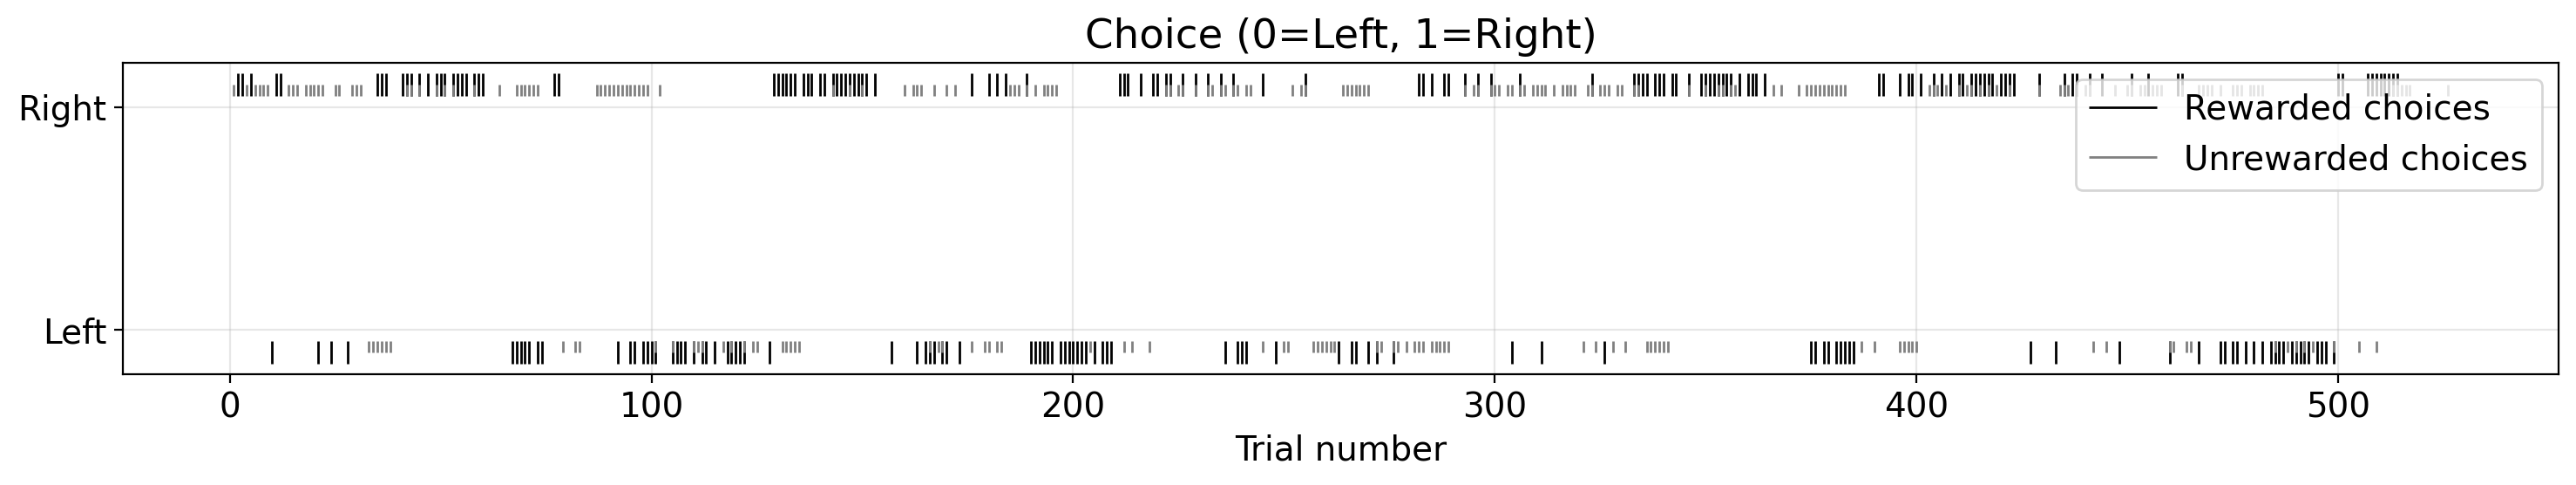

In [8]:
# variables needed for this plot: choice_history_real_data, reward_history_real_data
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)

rewarded_trials = reward_history_real_data == 1
unrewarded_trials = reward_history_real_data == 0
xx = np.nonzero(rewarded_trials)[0] + 1
yy_temp = choice_history_real_data[rewarded_trials]
yy_right = yy_temp[yy_temp > 0.5] + 0.05
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5] - 0.05
xx_left = xx[yy_temp < 0.5]

# Rewarded choices
ax.vlines(xx_right, yy_right, yy_right + 0.1, alpha=1, linewidth=1, color="black", label="Rewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left, alpha=1, linewidth=1, color="black")

unrewarded_trials = reward_history == 0
xx = np.nonzero(unrewarded_trials)[0] + 1
yy_temp = choice_history[unrewarded_trials]
yy_right = yy_temp[yy_temp > 0.5]
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5]
xx_left = xx[yy_temp < 0.5]

# Unrewarded choices
ax.vlines(xx_right, yy_right + 0.05, yy_right + 0.1, alpha=1, linewidth=1, color="gray", label="Unrewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left - 0.05, alpha=1, linewidth=1, color="gray")

# Set up axis labels and limits
ax.set_xlabel('Trial number')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Left', 'Right'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.title('Choice (0=Left, 1=Right)')
plt.tight_layout()
plt.show()# plotting of the data


**Question**: How to reveal what the animals are thinking? i.e. read the mouse's mind 


<div align="left"><img src="resources/mouse_left_right.png" width="200"></div>


<details>
<summary>Answer</summary>

through behavioral model fitting
</details>

# Behavioral Models


Model fitting is a powerful tool for making cognitive theories explicit, testable, and quantitatively precise. It typically involves:

1. **Simulation** – to understand what the model predicts.
2. **Parameter estimation** – to fit the model to data.
3. **Model comparison** – to evaluate competing hypotheses.




| Model Name                | Description                                                                 | Parameters $\theta$                                                                                  |
|---------------------------|-----------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| Rescorla-Wagner $\epsilon$-Greedy     | Value update via RPE and $\epsilon$-greedy action selection         | $\alpha$ (learning rate), $\epsilon$ (exploration rate)  |
| Win-Stay Lose-Shift (biased) | Repeat rewarded action, switch after loss, with bias                        | $b_L$ (bias towards left choice)                                                                                    |


## Model 1: Rescorla-Wagner Epsilon-Greedy

This model captures how action values are incrementally adjusted over time. The expected value of each action is updated based on the discrepancy between received and expected outcomes. Specifically, the value of option $L$ on trial $t$, denoted $Q^L_t$, is updated according to:

$$
Q^L_{t+1} = Q^L_t + \alpha c^L_t (r_t - Q^L_t)
$$

To translate learned values into choices, one way is to use $\epsilon$ greedy stratefy, balancing exploration versus exploitation. 
$$
c_t =
\begin{cases}
\text{random action}, & \text{with probability } \epsilon \\
\arg\max_{k \in \{L,R\}} Q^k, & \text{with probability } 1 - \epsilon
\end{cases}
$$



<details>
<summary> Denotations </summary>

- $c^L_t \in \{0,1\}$ is an indicator function of choosing left on trial $t$ 
- $r_t \in \{0,1\}$ is the reward on trial $t$,
- $\alpha \in [0, 1]$ is the **learning rate**, controlling how strongly the prediction error $(r_t - Q^L_t)$ updates the value,
- $Q^L_0$ is typically initialized to zero or treated as a free parameter.
</details>



---

## Model 2: Biased Win-Stay Lose-Shift 

If the agent received a reward for choosing an action on the previous trial (a win), it repeats that action; if the agent did not receive a reward (a loss), it switches to the alternative action on the next trial. To take account of the agent's preferrance of one decision over another, often a bias parameter ($b_L$) is included.


<div align="center">

**List all outcomes:**

| Previous Choice | Previous Reward | Probability of Choosing L at $t$ |
|-----------------|----------------|:--------------------------------:|
| Left  | Win  | $ (b_L + 1) / (b_L + 1)$ = 1 |
| Left  | Loss | $(b_L) / (b_L + 1)$           |
| Right | Win  | $(b_L) / (b_L + 1)$           |
| Right | Loss | $(b_L + 1) / (b_L + 1)$ = 1   |

</div>



<details>
<summary >Model 2 Variant: Loss Counting with Probabilistic Threshold </summary>



A more general variant of the win-stay lose-shift model is loss counting with a probabilistic threshold. The model switches arms when the count of loss (no reward) $\ell_t$ from one arm exceed a (stochastic) loss threshold $\tau_t$ with mean $\mu_{LC}$ and variance $\sigma_{LC}$. 

Action switches when 
$$
l_t \ge \tau_t
$$

Redraw threshold when switching
$$
\tau_{t+1} \sim \mathcal{N}(\mu_{LC},\sigma_{LC}^2) 
$$


The model is parameterized by:
$
\boldsymbol{\theta} = (\mu_{LC},\sigma_{LC})
$

</details>

## Step 1: simulation:

- Simulate surrogate data from models and task variants
- Compare behaviors across models and parameters


### Environment initialization
First we want to initialize a world environment which will interact with the agent to give feedback, including reward/force switch etc. This is like the rules for the task. The `UncoupledBlockTask` is a wrapped environment where reward probabilities for each action (e.g., left or right) change **independently** across blocks of trials.

<details>
<summary><b> Class UncoupledBlockTask explained </b></summary>

**Overview**

- The `UncoupledBlockTask` class implements a dynamic foraging environment where reward probabilities for left and right choices change **independently** across blocks of trials.

**Initialization Arguments**
- `reward_baiting`: `bool = False`
  - Whether rewards persist until collected
  - `True`: Uncollected rewards remain available
  - `False`: Rewards are generated fresh each trial

- `allow_ignore`: `bool = False`
  - Whether agent can skip trials
  - `True`: Adds "ignore" as third action option
  - `False`: Agent must choose left or right

- `num_arms`: `int = 2`
  - Number of choice options (typically 2 for left/right)

- `num_trials`: `int = 1000`
  - Total number of trials in the session

- `seed`: `int = None`
  - Random seed for reproducibility

- `rwd_prob_array`: `List[float] = [0.1, 0.5, 0.9]`
  - Available reward probabilities for block assignment
  - Each new block randomly selects from this array

- `block_min`: `int = 20`
  - Minimum block length in trials

- `block_max`: `int = 35`
  - Maximum block length in trials

- `persev_add`: `bool = True`
  - Enable anti-perseveration mechanism

- `perseverative_limit`: `int = 4`
  - Number of consecutive choices on min-prob side to trigger anti-persev

- `max_blocc_tally`: `int = 4`
  - Maximum consecutive blocks one side can be better before forced balancing

**Key Methods**

- `reset()`: Initialize new session with fresh block schedule
- `step(action)`: Execute one trial and return (observation, reward, done, info)
- `generate_new_trial()`: Create reward probabilities for next trial
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data
- `get_p_reward()`: Get reward probability matrix for analysis
- `plot_reward_schedule()`: Visualize block structure and choice patterns


</details>

In [3]:
task = UncoupledBlockTask(reward_baiting=False, num_trials=100, seed=42)

### Agent initialization

Next we want to initialize an agent which will interact with the task environment following its internal algorithm such as Q-learning. `ForagerQLearning` is a sophisticated reinforcement learning agent that implements Q-learning for dynamic foraging tasks. 


<details>
<summary><b> class ForagerQLearning explained </b></summary>

**Overview:**

The `ForagerQLearning` class is a flexible reinforcement learning agent that incrementally updates action-value estimates (Q-values) based on reward history, supports different learning rates/forget rates for rewarded versus unrewarded outcomes, and can incorporate choice history effects through choice kernels. 

**Initialization configs:**
- `number_of_learning_rate`: `Literal[1, 2] = 2`
  - Controls learning rate structure
  - `1`: Single learning rate for all outcomes
  - `2`: Separate rates for rewarded (`learn_rate_rew`) and unrewarded (`learn_rate_unrew`) outcomes

- `number_of_forget_rate`: `Literal[0, 1] = 1`
  - Controls forgetting mechanism
  - `0`: No forgetting of unchosen options
  - `1`: Includes `forget_rate_unchosen` parameter

- `choice_kernel`: `Literal["none", "one_step", "full"] = "none"`
  - Choice history influence on decisions
  - `"none"`: No choice history effects
  - `"one_step"`: Only immediate previous choice (Bari2019 style)
  - `"full"`: Exponentially weighted choice history with learnable parameters

- `action_selection`: `Literal["softmax", "epsilon-greedy"] = "softmax"`
  - Decision strategy
  - `"softmax"`: Probabilistic selection with inverse temperature parameter
  - `"epsilon-greedy"`: Exploration with fixed epsilon probability

- `params`: `dict = {}`
  - Initial model parameters (auto-generated based on configuration)
  - Learning rates: `learn_rate`, `learn_rate_rew`, `learn_rate_unrew` (0.0-1.0)
  - Forget rates: `forget_rate_unchosen` (0.0-1.0)
  - Bias: `biasL` (left side bias, -5.0 to 5.0)
  - Action selection: `softmax_inverse_temperature` (0.0-100.0) or `epsilon` (0.0-1.0)
  - Choice kernel: `choice_kernel_relative_weight`, `choice_kernel_step_size` (0.0-1.0)

- `**kwargs`: Additional arguments passed to base class (e.g., `seed` for reproducibility)

**Key Methods:**

- `perform(task)`: Simulate agent behavior on a foraging task
- `fit(choice_history, reward_history)`: Fit model parameters to behavioral data
- `act(observation)`: Select action based on current Q-values
- `learn(observation, action, reward, next_observation, done)`: Update Q-values after action
- `plot_session()`: Visualize behavioral session and internal states
- `get_choice_history()`, `get_reward_history()`: Extract behavioral data

</details>

In [61]:
forager_RW = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")

**Exercise**: describe this Q-learning model

1. How is the learning rate going to be updated? Same for all choices or differentiate between rewarded and unrewarded choices?
2. What is the forget mechanism? 
3. Is previous choice going to influece the choice structure? 
4. What is the decision strategy? 
5. What are the parameters associated? 

<details>
<summary><b> Answer </b></summary>

1. Same learning rate for all choices
2. No forgetting mechanism
3. No choice kernel
4. Epsilon-greedy decision strategy
5. Parameters: `forager.params`



### Agent interacting with task environment

In [77]:
# Simulate the model
forager_RW.perform(task)

In [78]:
# obtain behaviorial data from the forager
ground_truth_params = forager_RW.params.model_dump()
ground_truth_choice_prob = forager_RW.choice_prob
ground_truth_q_value = forager_RW.q_value
print("Ground Truth Parameters:", ground_truth_params)
# Get the history
choice_history = forager_RW.get_choice_history() # 0: Left, 1: Right
reward_history = forager_RW.get_reward_history() # 0: Unrewarded, 1: Rewarded
p_reward = forager_RW.task.get_p_reward() # row 0: Left, row 1: Right


Ground Truth Parameters: {'learn_rate': 0.5, 'biasL': 0.0, 'epsilon': 0.1}


#### Visualization of reward probability of two arms in the task

Reward probability in two ports alternate independently between: [0.1 0.5 0.9]


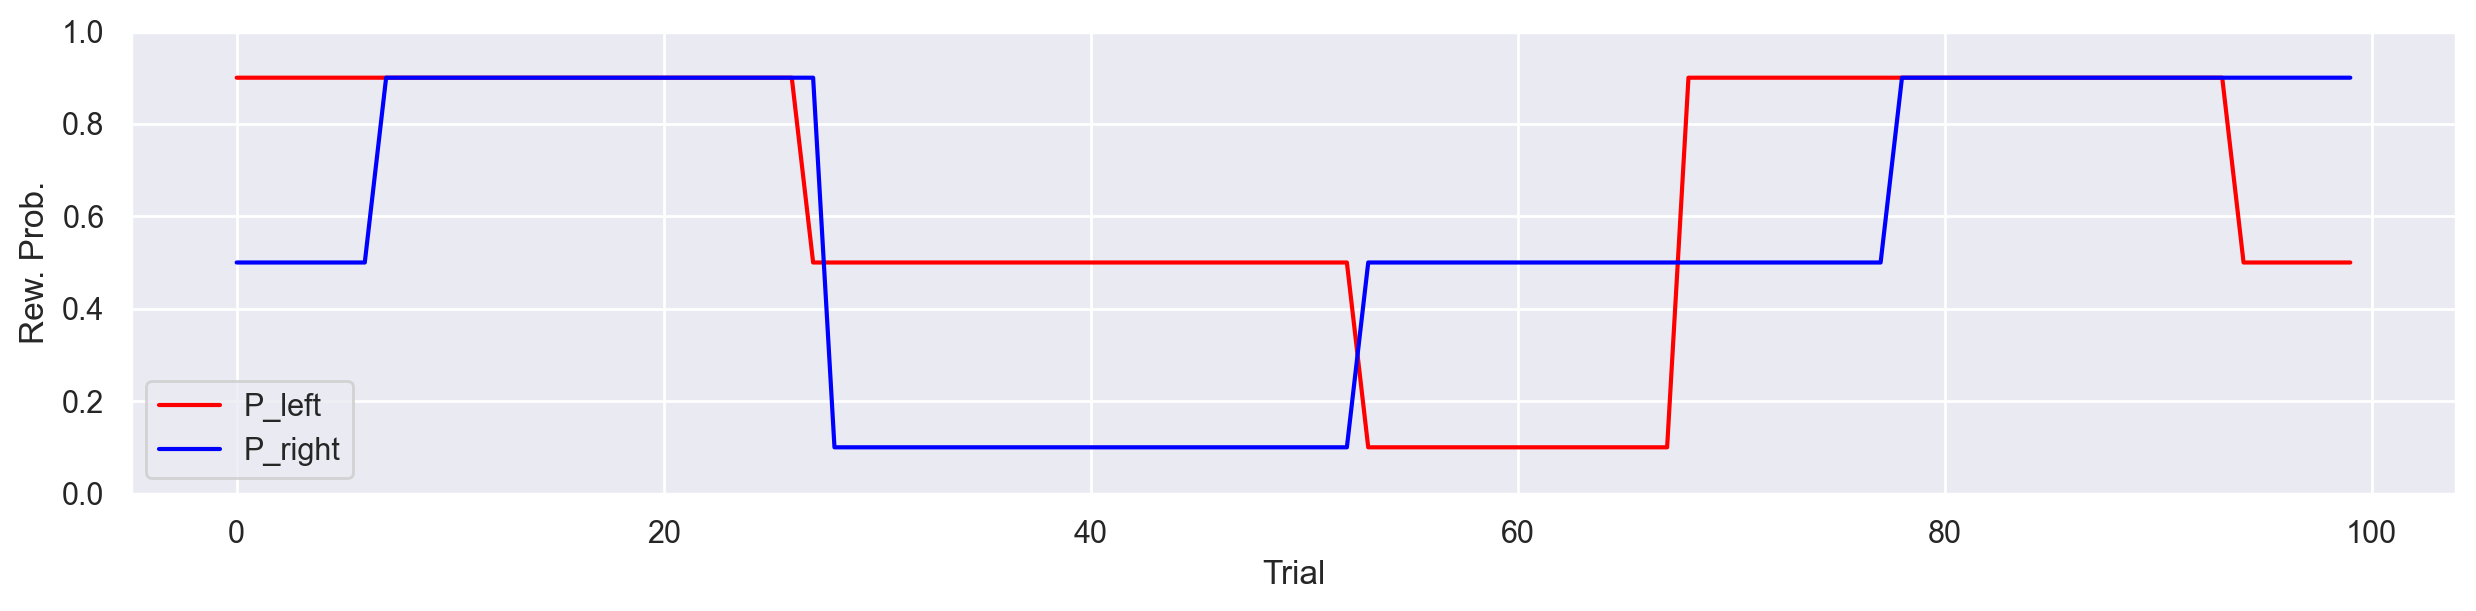

In [79]:
# reward probabilities fluctuate over trials between [0.1, 0.5, 0.9]
print('Reward probability in two ports alternate independently between:', np.unique(p_reward))
# visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)
ax.plot(task.get_p_reward()[0], label='P_left', color='red')
ax.plot(task.get_p_reward()[1], label='P_right', color='blue')
ax.set_ylim(0, 1)
ax.set_xlabel('Trial')
ax.set_ylabel('Rew. Prob.')
ax.legend()

#### Visualization choices by the simulated agent

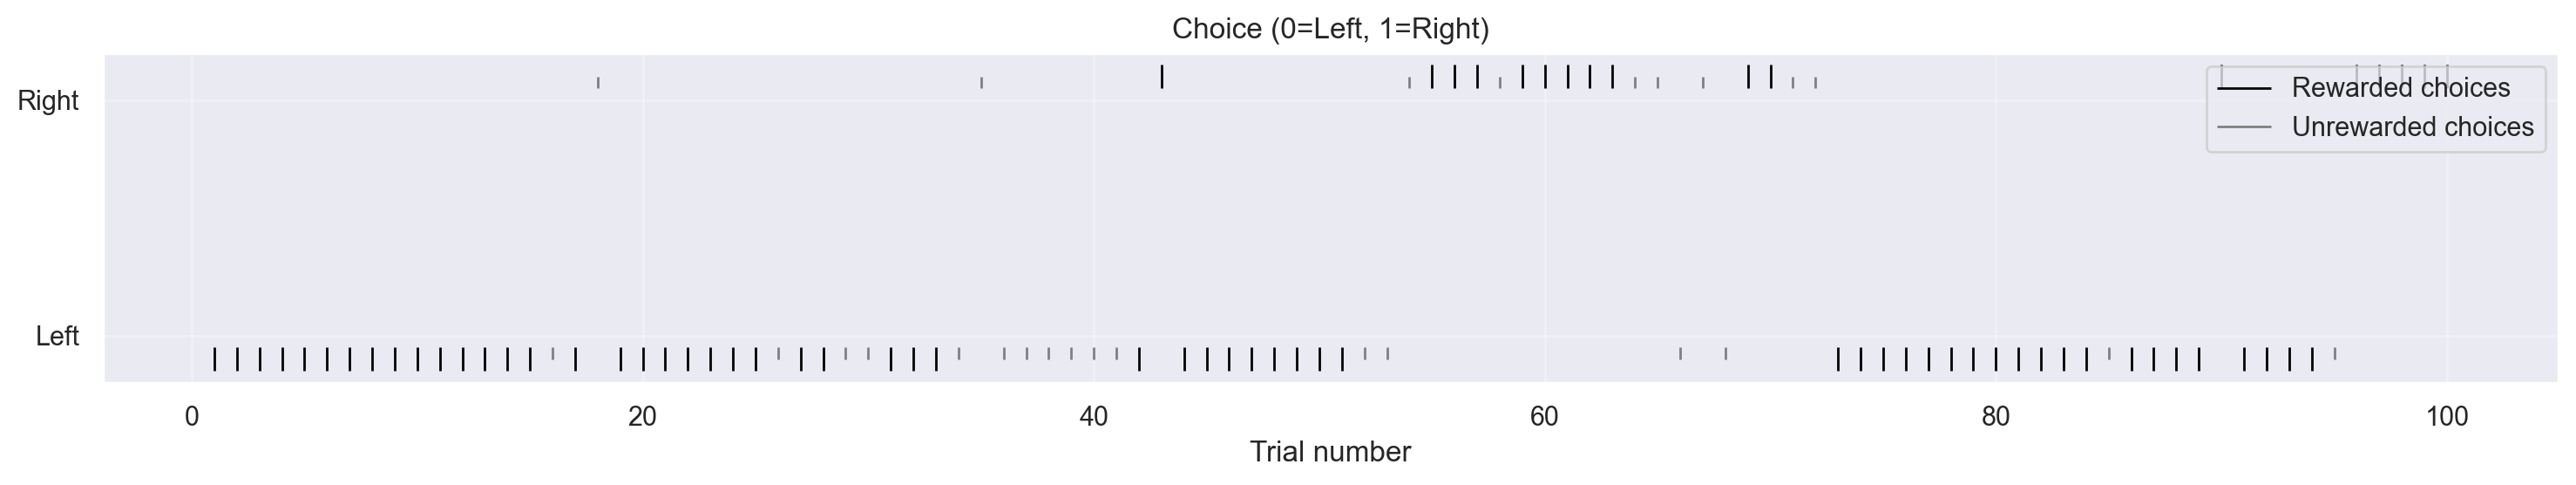

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=200)

rewarded_trials = reward_history == 1
unrewarded_trials = reward_history == 0
xx = np.nonzero(rewarded_trials)[0] + 1
yy_temp = choice_history[rewarded_trials]
yy_right = yy_temp[yy_temp > 0.5] + 0.05
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5] - 0.05
xx_left = xx[yy_temp < 0.5]

# Rewarded choices
ax.vlines(xx_right, yy_right, yy_right + 0.1, alpha=1, linewidth=1, color="black", label="Rewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left, alpha=1, linewidth=1, color="black")

unrewarded_trials = reward_history == 0
xx = np.nonzero(unrewarded_trials)[0] + 1
yy_temp = choice_history[unrewarded_trials]
yy_right = yy_temp[yy_temp > 0.5]
xx_right = xx[yy_temp > 0.5]
yy_left = yy_temp[yy_temp < 0.5]
xx_left = xx[yy_temp < 0.5]

# Unrewarded choices
ax.vlines(xx_right, yy_right + 0.05, yy_right + 0.1, alpha=1, linewidth=1, color="gray", label="Unrewarded choices")
ax.vlines(xx_left, yy_left - 0.1, yy_left - 0.05, alpha=1, linewidth=1, color="gray")

# Set up axis labels and limits
ax.set_xlabel('Trial number')
ax.set_ylim(-0.2, 1.2)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Left', 'Right'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.title('Choice (0=Left, 1=Right)')
plt.tight_layout()
plt.show()

#### Visualization of choice statistics
1. Base reward probabilities = p_right / (p_right + p_left)
2. Choice = moving average of choice history, i.e. moving average of choosing right 
3. Q(L) (`ground_truth_q_value[0,:]`): ground truth q value for left choice
4. Q(R) (`ground_truth_q_value[1,:]`): ground truth q value for right choice
5. choice_prob(R/R+L) (`ground_truth_choice_prob[1] / ground_truth_choice_prob.sum(axis=0)`): choice probability normalized


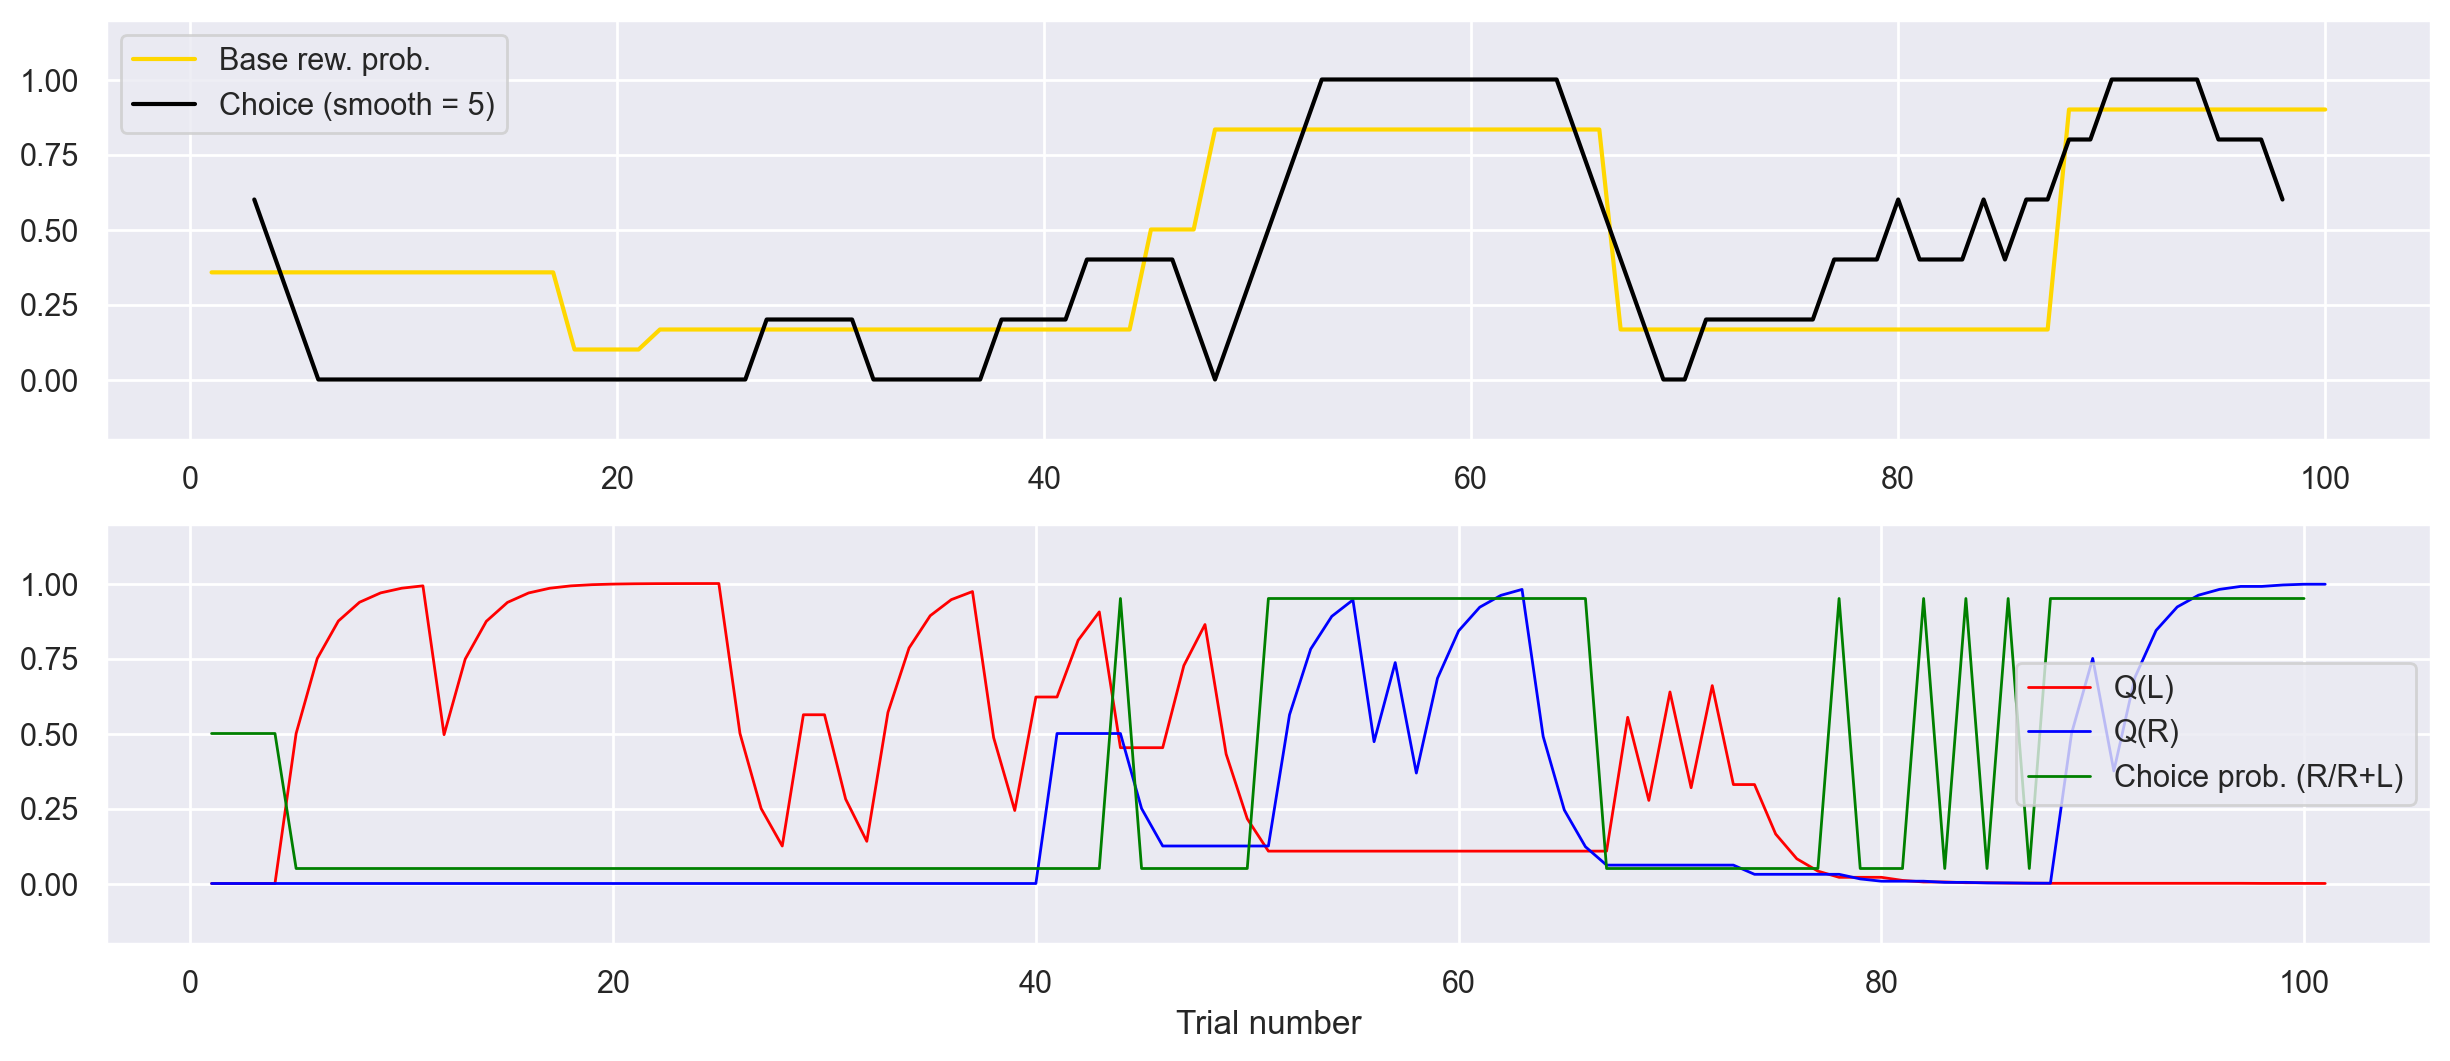

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), dpi=200)

def moving_average(a, n=3):
    """Compute moving average of a list or array."""
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n - 1):] / n

n_trials = len(choice_history)
smooth_factor = 5  

ax = axs[0]
ax.plot(np.arange(1,n_trials+1), p_reward[1, :] / (np.sum(p_reward, axis=0)),
         color="gold",label="Base rew. prob.",lw=1.5,)
y = moving_average(choice_history, n=smooth_factor)
ax.plot(np.arange(0, len(y)) + int(smooth_factor / 2) + 1, y,
        linewidth=1.5,color="black",label="Choice (smooth = %g)" % smooth_factor)
ax = axs[1]
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[0, :], lw=1, color="red", ls="-", label="Q(L)")
ax.plot(np.arange(1,n_trials+2), ground_truth_q_value[1, :], lw=1, color="blue", ls="-", label="Q(R)")
ax.plot(np.arange(1,n_trials+1), ground_truth_choice_prob[1] / np.sum(ground_truth_choice_prob, axis=0), lw=1, color="green", ls="-", label="Choice prob. (R/R+L)")

axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('Trial number')
axs[0].set_ylim(-0.2, 1.2)
axs[1].set_ylim(-0.2, 1.2)
plt.show()

Question: why are Q values fluctuctuating?

<details>
<summary><b> Answer </b></summary>
Unrewarded / unexpected choice outcome
</details>

#### Visualization on one plot

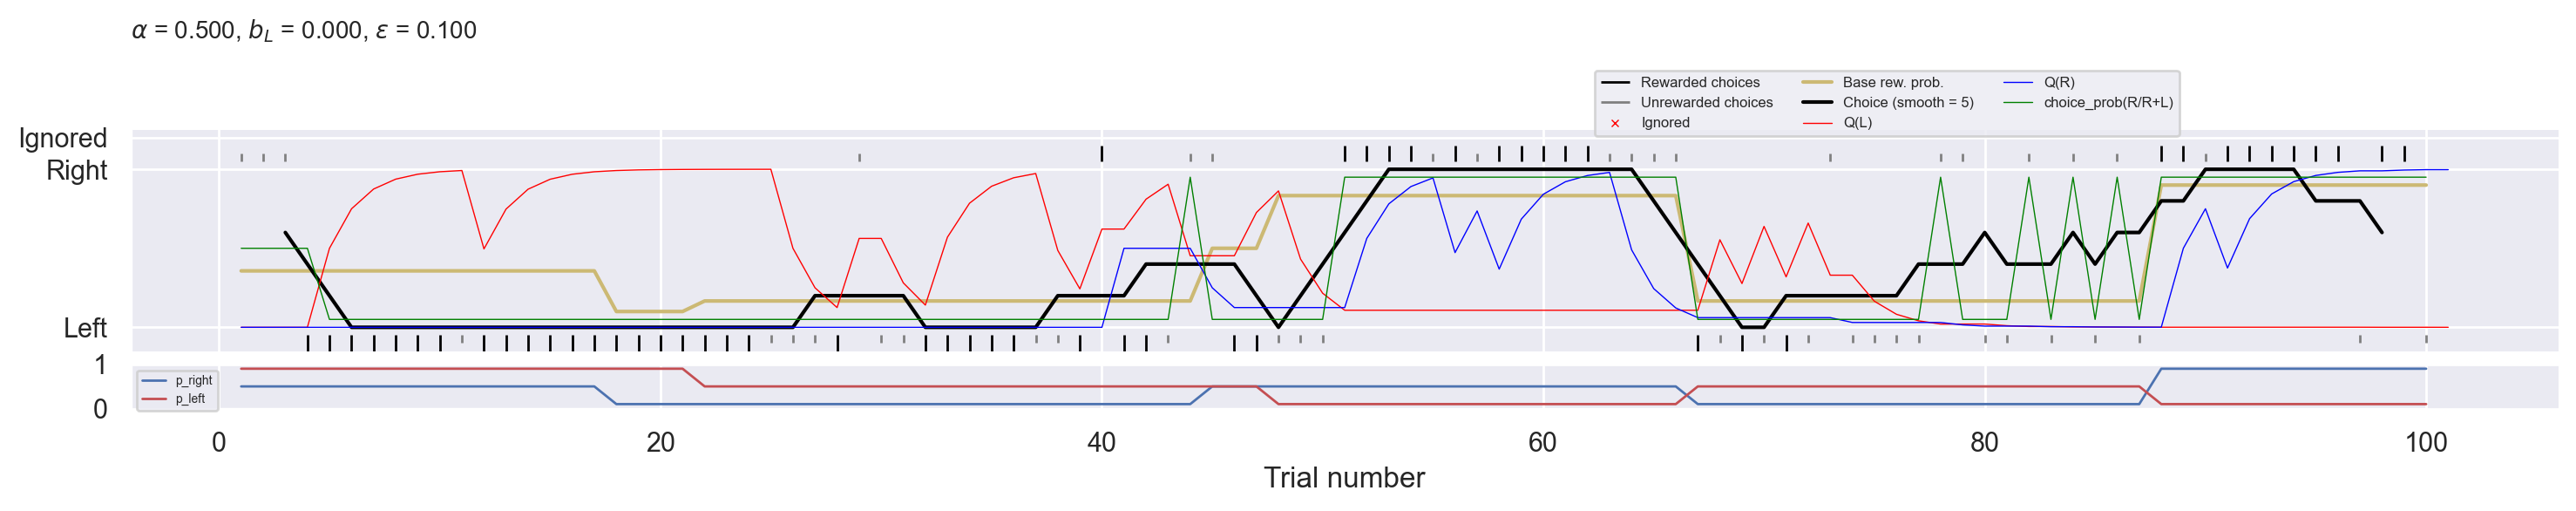

In [ ]:
fig, axes = forager_RW.plot_session(if_plot_latent=True)

**Exercise**: 
Use another set of parameters and simulate more choices

learn_rate=0.5 forget_rate_unchosen=0.2 biasL=0.0 epsilon=0.1


(<Figure size 3000x600 with 2 Axes>, [<Axes: >, <Axes: xlabel='Trial number'>])

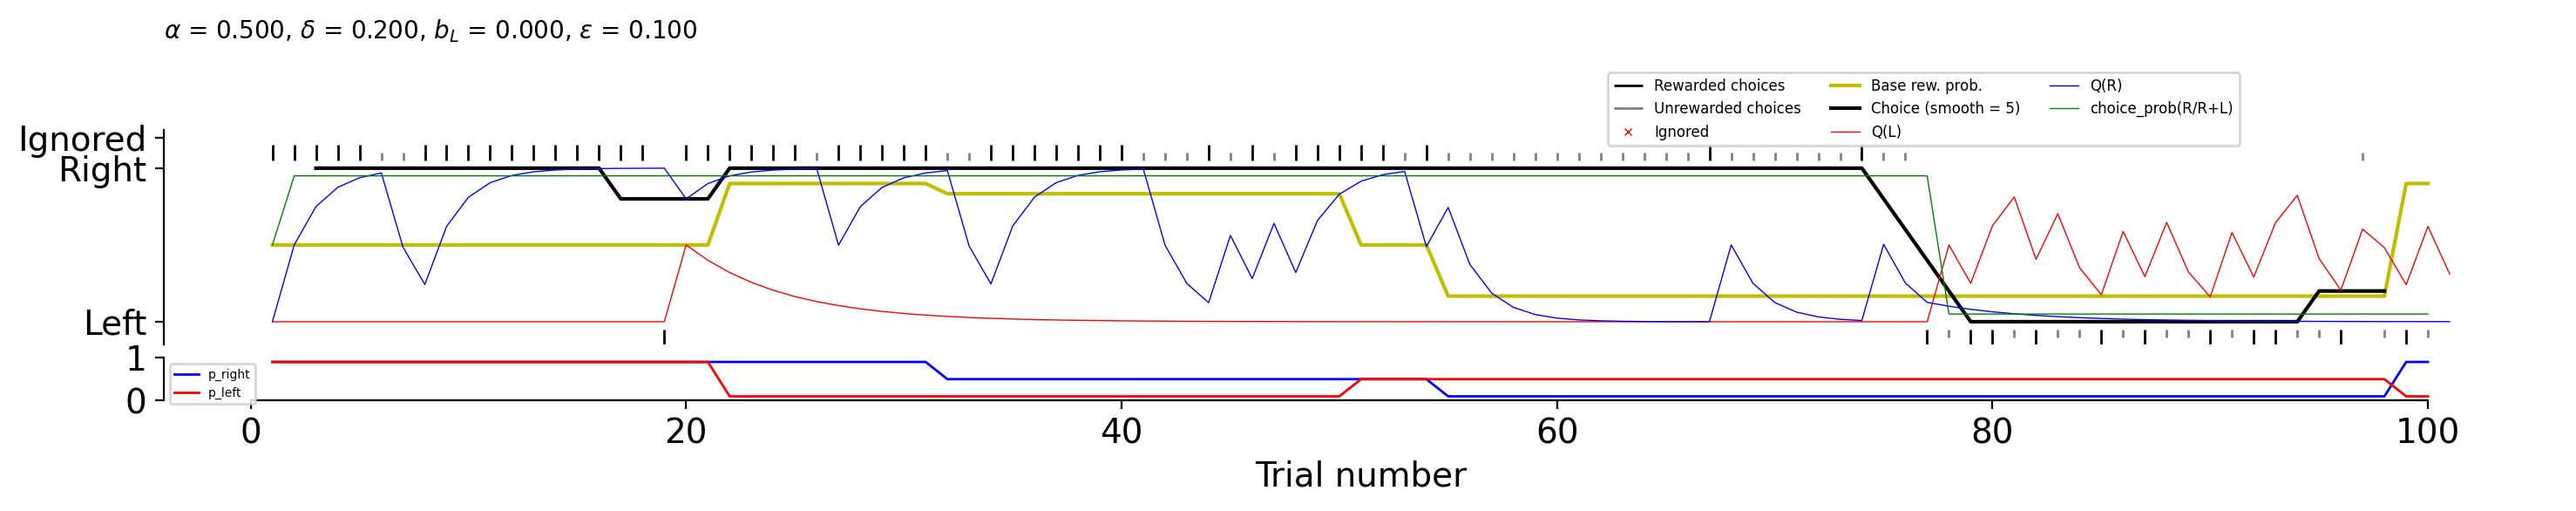

In [15]:
forager_RW2 = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=1,choice_kernel="none",action_selection="epsilon-greedy")
print(forager_RW2.params)
forager_RW2.perform(task)
forager_RW2.plot_session(if_plot_latent=True)

## Step2: Parameter Recovery
Parameter estimation refers to **inferring model parameters** that best explain observed behavior.
Parameters are typically inferred using **maximum likelihood** or **Bayesian methods**.

<details>
<summary> Maximum Likelihood explained </summary>

The observed data  $d_{1:T}$ includes **choice history** $c_t \in \{\text{L}, \text{R}\}$ and **reward history** $r_t \in \{0,1\}$
<!-- - **Reward history**: rewards associated with left and right actions:
  - $r_{R,t}$: reward received when choosing right at time $t$
  - $r_{L,t}$: reward received when choosing left at time $t$
 -->

To fit a model to behavioral data, we estimate the parameters $\boldsymbol{\theta}_M$ that maximize the likelihood of the observed data under model $M$. This is typically done using **maximum likelihood estimation (MLE)**:

$$
\hat{\boldsymbol{\theta}}^{\text{MLE}}_M = \arg\max_{\boldsymbol{\theta}_M} \log p(d_{1:T} \mid \boldsymbol{\theta}_M, M) = \arg\max_{\boldsymbol{\theta}_M} \sum_{t=1}^{T} \log p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}_M, M)
$$

</details>

### Example: RW epsilon greedy

Now we have access to the simulated agent's choices and environment feedback. How can we obtain the agent's parameter, which govern its choices from Q-learing model? We could utilize the `fit` function associated with `forager` class. 

<details>
<summary><b> forager.fit() explained </b></summary>

**Main purpose** 

Finds the model parameters that maximize the likelihood of observing the actual choice and reward history. Computes model evaluation metrics (AIC, BIC, prediction accuracy). Optionally cross-validation.

**Inputs** 
- `fit_choice_history` / `fit_reward_history`: Behavioral data to fit
- `clamp_params`: Fix specific parameters (e.g., `{"biasL": 0}`)
- `fit_bounds_override`: Custom parameter bounds for fitting
- `k_fold_cross_validation`: Number of CV folds (None = no CV)
- `DE_kwargs`: Optimization settings (workers, seed, etc.)

**Outputs**
- `fitting_result`: Best parameters, likelihood, AIC/BIC, prediction accuracy
- `fitting_result_cross_validaiton` (if requested): Test accuracies across folds


</details>


In [34]:
# simulate data
forager_RW = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0,choice_kernel="none",action_selection="epsilon-greedy")
ground_truth_params = forager_RW.params.model_dump()
print(ground_truth_params)
task = UncoupledBlockTask(reward_baiting=False, num_trials=100, seed=42)
forager_RW.perform(task)
choice_history = forager_RW.get_choice_history()
reward_history = forager_RW.get_reward_history()
ground_truth_q_value = forager_RW.q_value


{'learn_rate': 0.5, 'biasL': 0.0, 'epsilon': 0.1}


In [40]:
# fit a new model
forager_RW.fit(
    choice_history,
    reward_history,
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager_RW.fitting_result

2025-08-15 17:40:33,058 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 17.46414436846153
differential_evolution step 2: f(x)= 17.46414436846153
differential_evolution step 3: f(x)= 17.457220212721463
differential_evolution step 4: f(x)= 17.457220212721463
differential_evolution step 5: f(x)= 17.446884084962505
differential_evolution step 6: f(x)= 17.446713687305103
differential_evolution step 7: f(x)= 17.44663769152651
differential_evolution step 8: f(x)= 17.44653510711927
differential_evolution step 9: f(x)= 17.44653510711927
differential_evolution step 10: f(x)= 17.44653510711927
differential_evolution step 11: f(x)= 17.446531773687777
differential_evolution step 12: f(x)= 17.446531773687777
Polishing solution with 'L-BFGS-B'


In [41]:
# Check fitting performance and results
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 100
Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.6027', '0.0808']
Likelihood-Per-Trial: 0.8399059968041185
Prediction accuracy full dataset: 0.96



Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.6027', '0.0808']


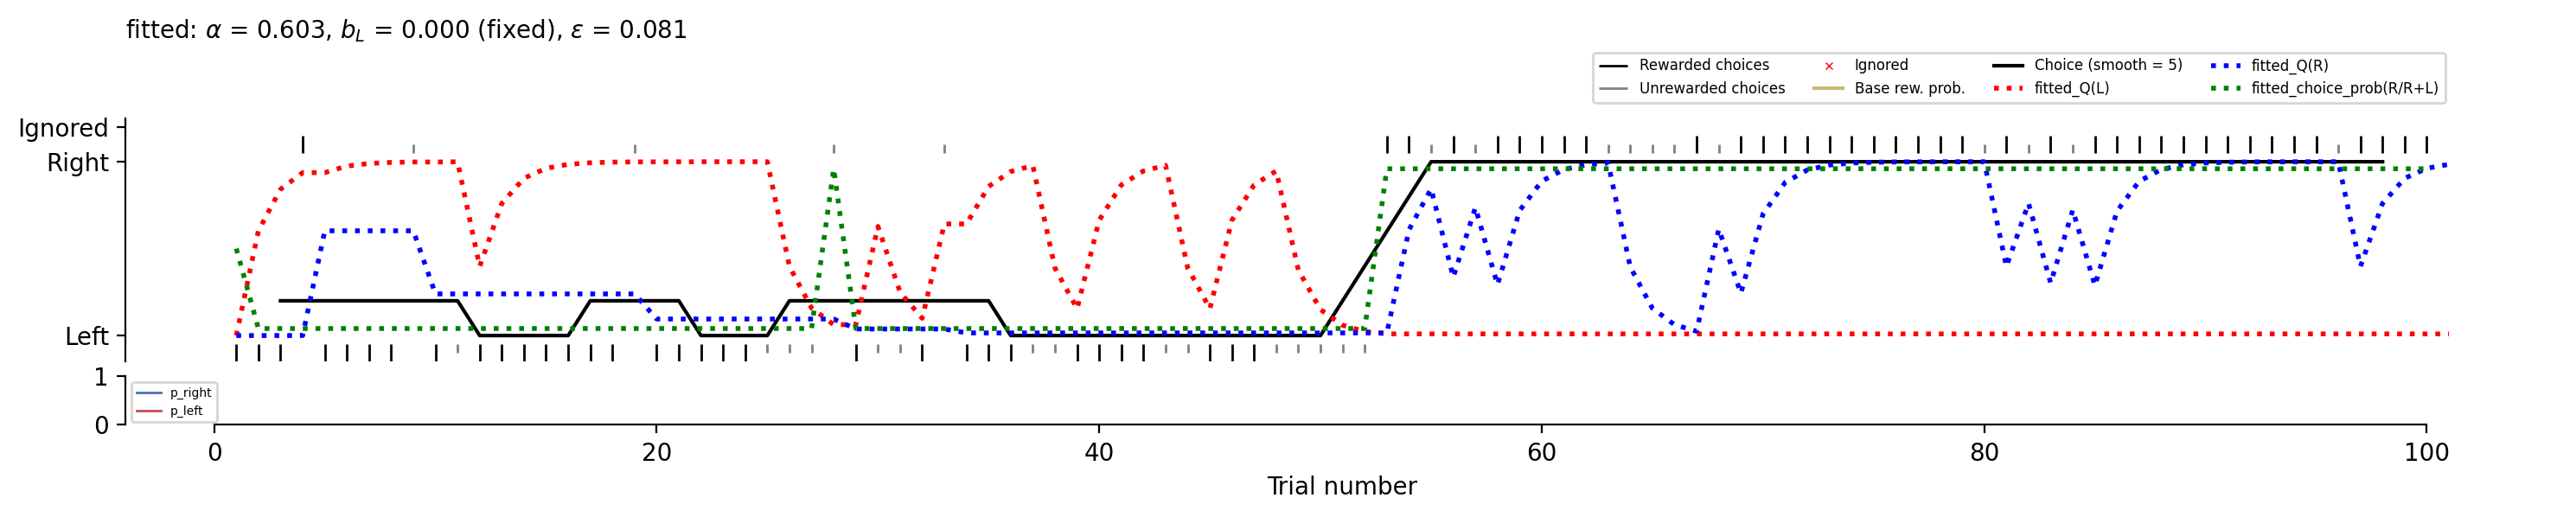

In [42]:
# Plot the fitted session results
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
fig_fitting, axes = forager_RW.plot_fitted_session(if_plot_latent=True)

Fitted parameters: ['learn_rate', 'epsilon']
Ground truth: ['0.5000', '0.1000']
Fitted:       ['0.6027', '0.0808']


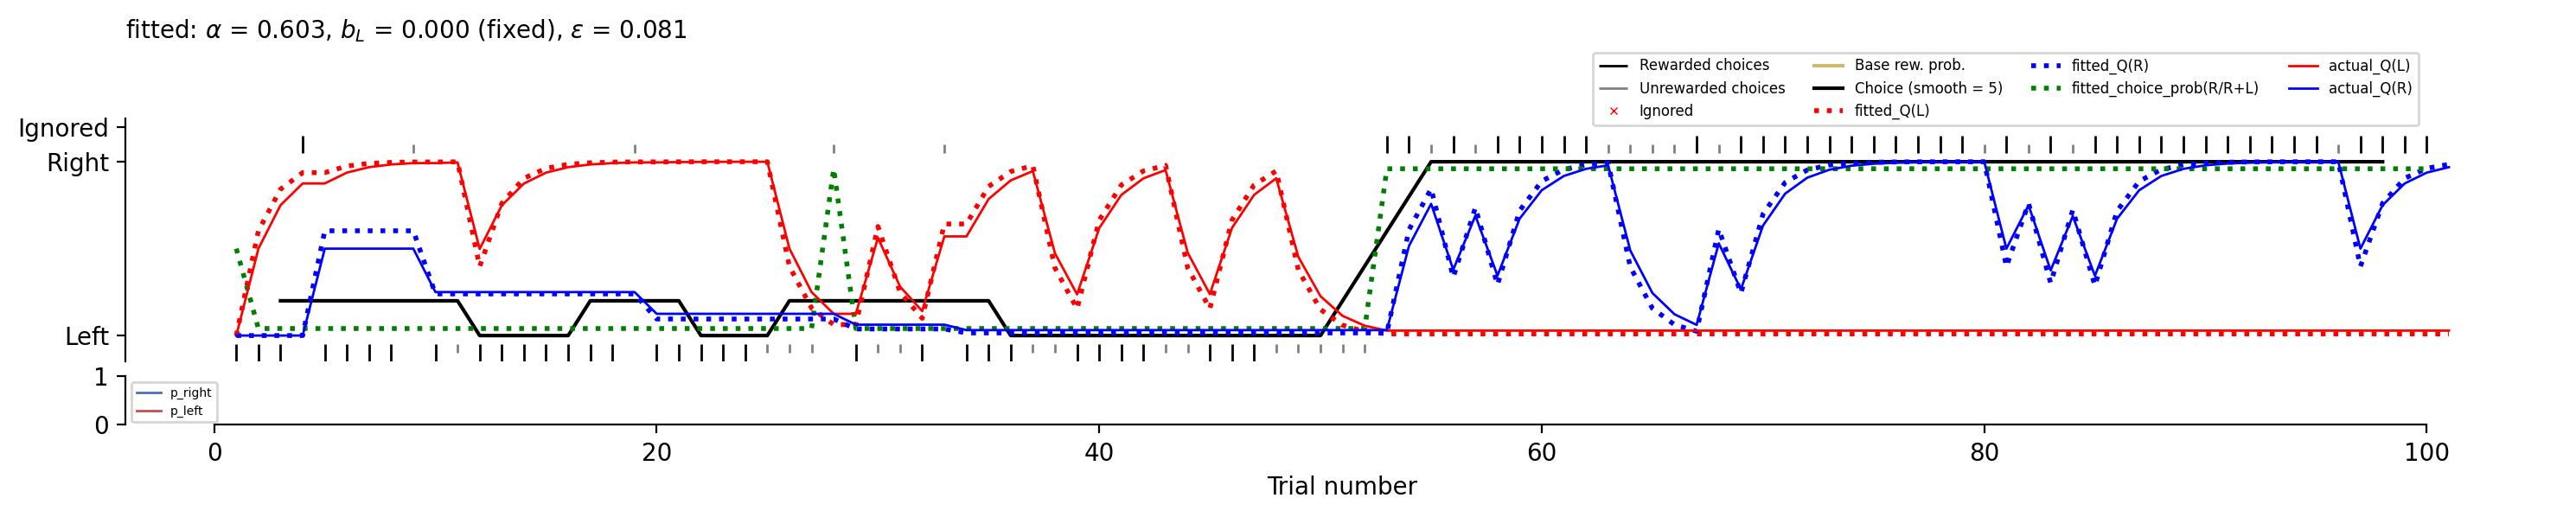

In [43]:
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
fig_fitting, axes = forager_RW.plot_fitted_session(if_plot_latent=True)
xx = np.arange(1, len(ground_truth_q_value[0]) + 1)
axes[0].plot(xx, ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(xx, ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

**Question**: Why the inferred learning rate/epsilon don't match ground truth but the fitted latent variables still look the same? Can you resolve this?

<details>
<summary><b> Answer </b></summary>
Insufficient trial numbers AND indistinguishable loss landscape
</details>

Let's visualize how model fitness change with respect to parameters

Fitting using L-BFGS-B (n_x0s = 8), pool = True...
  True para: [0.5 0.1]
Fitted para: [0.407 0.28 ]
km = 2, AIC = 118.176, BIC = 123.406
      LPT_AIC = 0.557, LPT_BIC = 0.543


/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:4405: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


the shape of x is  (97,)
the shape of y is  (97,)


LL_surface pair #0: 100%|██████████| 400/400 [00:02<00:00, 161.73it/s]


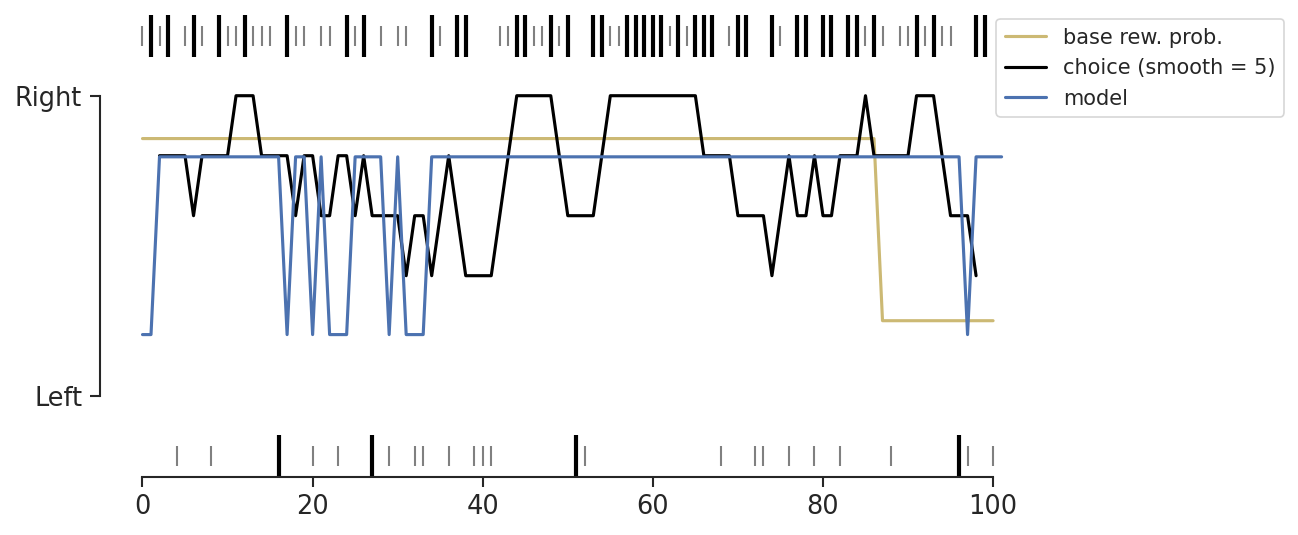

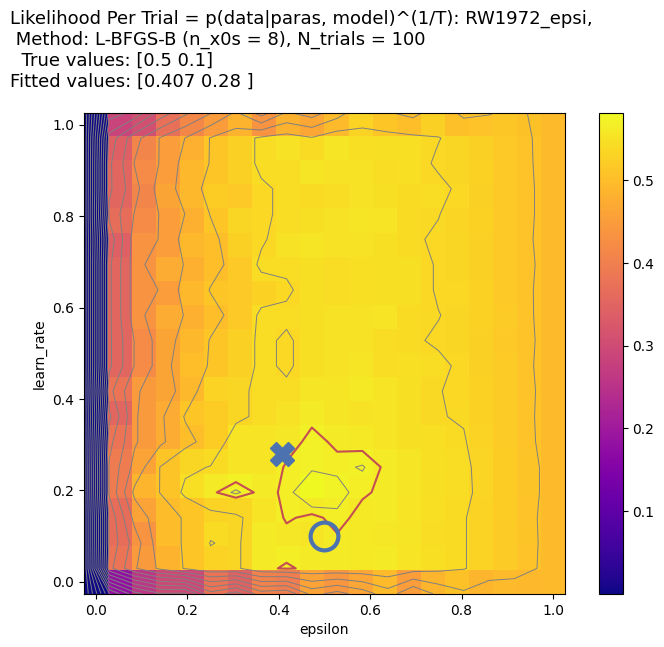

In [44]:
n_worker = int(mp.cpu_count() / 2)
compute_LL_surface('RW1972_epsi', ['epsilon', 'learn_rate'], [[0,0],[1,1]],
                   true_para = [0.5,0.1], n_trials = 100,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool=mp.Pool(processes = n_worker))



### Example: win-stay-lose-shift
<!-- 

The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions.

In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of choosing option k is: 

Let $c_t \in \{1, 2\}$ be the choice at trial $t$, and $r_t \in \{0, 1\}$ the reward at trial $t$. Then:
 -->


Now let's initialize an artificial agent with biased 'win-stay-lose-shift' algorithm with `ForagerLossCounting` class

<details>
<summary><b> class ForagerLossCounting explained </b></summary>

**Overview:**

The `ForagerLossCounting` class implements a simple, psychologically plausible agent that uses a loss-counting strategy to decide when to switch actions in a dynamic foraging task. Instead of tracking action values, the agent counts consecutive unrewarded trials (losses) for the current choice. When the loss count exceeds a threshold, the agent switches to the other option.

**Inputs**
- `win_stay_lose_switch`: Boolean, enables classic win-stay-lose-shift logic (default True). If true, `loss_count_threshold_mean` and `loss_count_threshold_std` are fixed at 1 and 0
- `choice_kernel`: String, controls influence of choice history ("none", "one_step", "full").
- `params`: dictionary with following keys
    - `loss_count_threshold_mean`: Mean threshold for switching after losses.
    - `loss_count_threshold_std`: Standard deviation for threshold (adds stochasticity).
    - `biasL`: Optional bias toward left choice.

**Unique Attributes**
- `loss_count`: number of consecutive unrewarded trials

</details>

In [37]:
# initialize the task
task = UncoupledBlockTask(reward_baiting=True, num_trials=100, seed=42)
# initialize the forager with 'win-stay-lose-shift' algorithm
forager_LC = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')
# fix some parameters
forager_LC.set_params(biasL=0.1)  
# extract the parameters
forager_LC.params.model_dump() # biasL term is not used here

{'loss_count_threshold_mean': 1.0,
 'loss_count_threshold_std': 0.0,
 'biasL': 0.1}

In [ ]:
forager_LC.perform(task)

# Capture the results
ground_truth_params = forager_LC.params.model_dump()
ground_truth_loss_count = forager_LC.loss_count
ground_truth_choice_prob = forager_LC.choice_prob

# Get the history
choice_history = forager_LC.get_choice_history()
reward_history = forager_LC.get_reward_history()

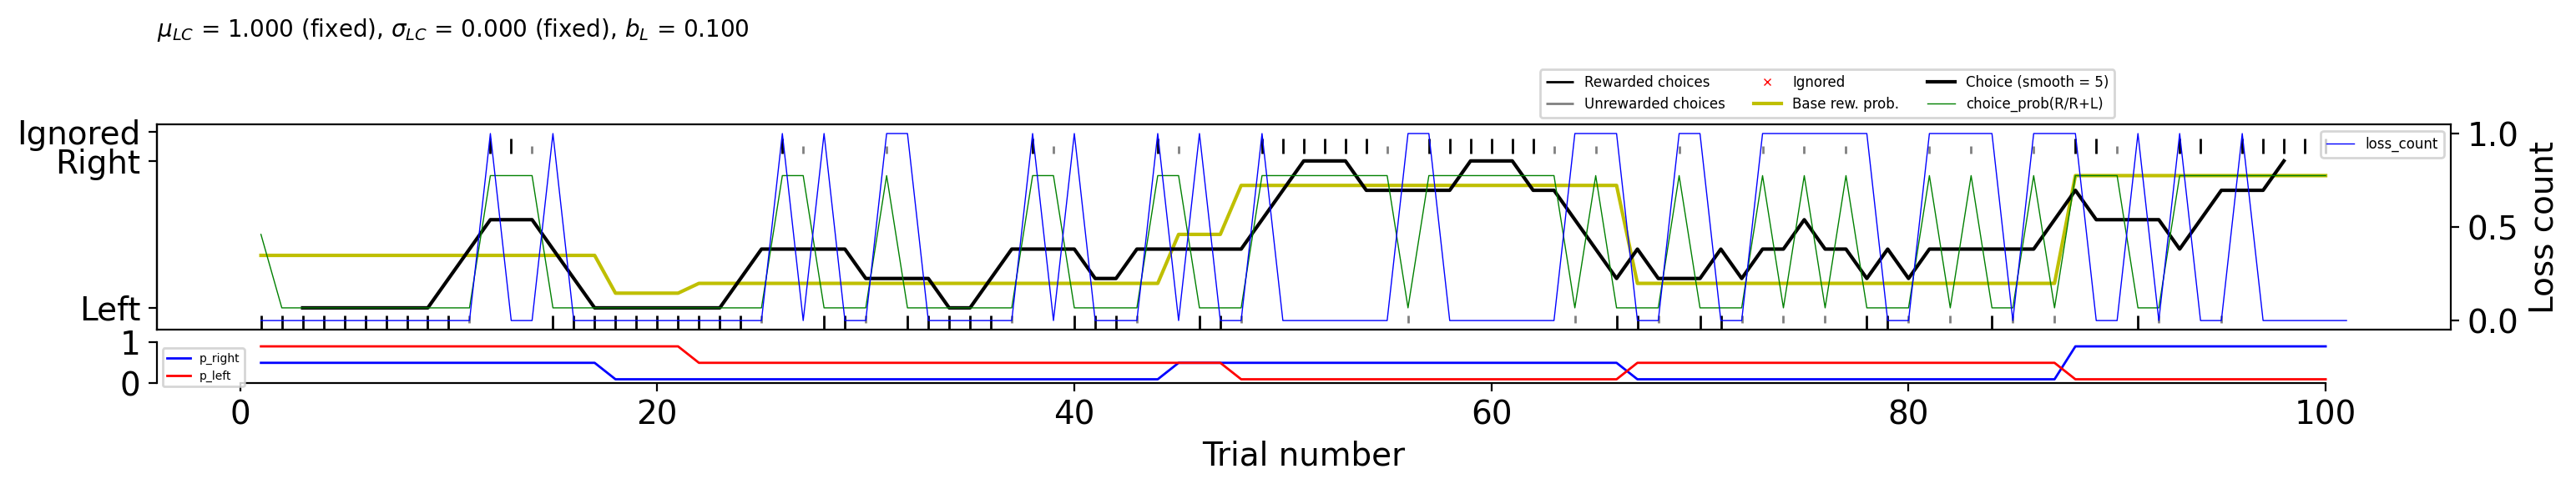

In [39]:
# Plot the session results
fig, axes = forager_LC.plot_session(if_plot_latent=True)

Notice the `loss_count` trace

In [40]:
# Fit the model to recover parameters
forager_LC_new = ForagerLossCounting(win_stay_lose_switch=True, choice_kernel='none')
forager_LC_new.fit(
    choice_history,
    reward_history,
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

fitting_result = forager_LC_new.fitting_result

2025-08-15 02:17:01,629 - utils_model_recovery - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 5.505466693174155
differential_evolution step 2: f(x)= 5.505466693174155
differential_evolution step 3: f(x)= 5.505466693174155
differential_evolution step 4: f(x)= 5.505466693174155
differential_evolution step 5: f(x)= 5.445006661263236
differential_evolution step 6: f(x)= 5.445006661263236
differential_evolution step 7: f(x)= 5.443469790698641
differential_evolution step 8: f(x)= 5.443085035845847
differential_evolution step 9: f(x)= 5.442985913186818
differential_evolution step 10: f(x)= 5.442628398266664
Polishing solution with 'L-BFGS-B'


In [41]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
print(fit_names)
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

['biasL']
Num of trials: 100
Fitted parameters: ['biasL']
Ground truth: ['0.1000']
Fitted:       ['0.0233']
Likelihood-Per-Trial: 0.9470283194368454
Prediction accuracy full dataset: 0.99



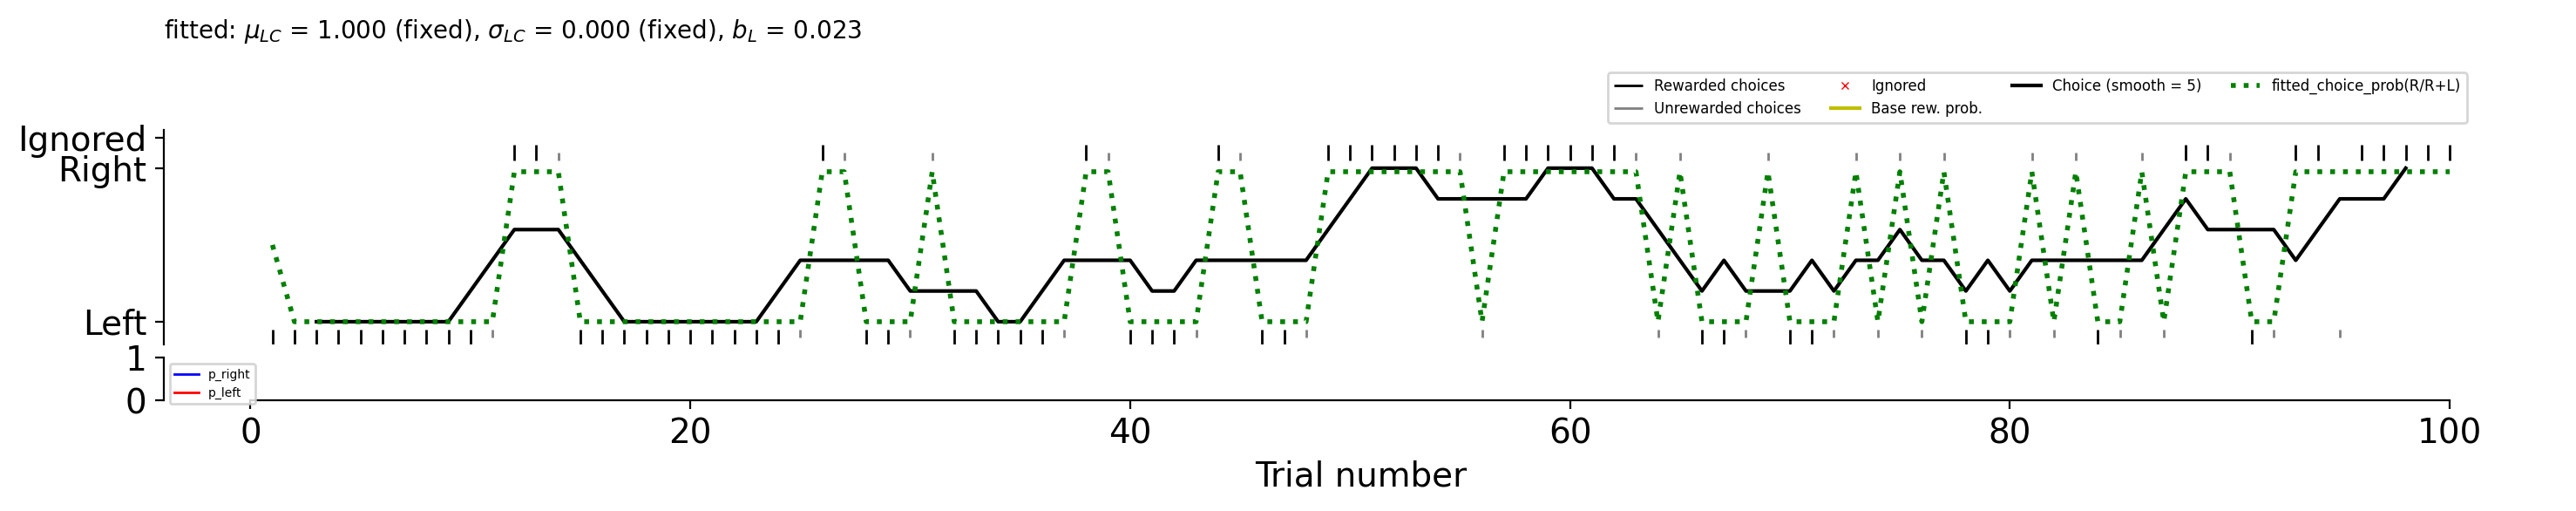

In [42]:
# Plot the fitted session results
fig_fitting, axes = forager_LC_new.plot_fitted_session(if_plot_latent=True)

### Recover parameter sets (Optional)

By simulating agents with a range of parameter combinations from a fixed model type, we can assess the identifiability and robustness of the model—determining whether the fitting procedure can reliably recover true parameters across diverse scenarios. This process is crucial for validating that the model is not only flexible enough to capture behavioral variability.



To do this, we can follow these steps: 

- Choose the model(s) $M_1, M_2, \dots$ you want to test (e.g. Rescorla–Wagner, WSLS).  
- For each model, define parameter ranges: e.g. Learning rate $\alpha \in [0.05, 0.9]$, inverse temperature $\sigma \in [0.5, 10]$  

- Simulate Behavioral Data: for every parameter draw $\boldsymbol{\theta}^{(i)}$:  
     1. Initialize model state (e.g., $Q^k_0 = 0$).  
     2. Loop over trials $t = 1 \dots T$:  
        - Sample choice $c_t \sim p(c_t \mid d_{1:t-1}, \boldsymbol{\theta}^{(i)}, M)$  
        - Sample outcome $r_t$ from the task’s reward schedule  
        - Update model states.  

- Compute Diagnostic Summaries such as choice-probability curves, use these summaries to confirm the simulated behavior matches the qualitative patterns you expect.

- Parameter-Recovery Check: fit the same model back to the simulated data. Good recovery (slope ≈ 1, $R^2$ high) indicates your model + fitting procedure can, in principle, retrieve true parameters.


#### Example: Loss Counting Model 

Generate multiple LossCounting model with different parameter sets. `fit_para_recovery` is a pre-packed function to do this

<details>
<summary><b> function fit_para_recovery explained </b></summary>

**Overview**
Generate fake data with given parameter and run model fitting to the fake data

**Inputs**
- `forager`:
     - str, model type identifier: e.g. `LossCounting` or `RW1972_softmax`, full list refer to the [dict] `forager_params` defined below, which maps forager names to their parameter lists. `learn_rate` has to be included for `RW1972` kind of model
- `para_names`: list[str]
- `para_bounds`: list[str], bound of optization range 
- `para_scales`: scales to display the plot (only for visualization)
- `true_paras`: numpy array 
- `fit_method`: str, Optimization algorithm: e.g. `DE` or `L-BFGS-B`

**Outputs**
- `true_paras`:	numpy.ndarray, (n_parameters, n_models), True parameter values used for simulation
- `fitted_paras`:numpy.ndarray, (n_parameters, n_models), Recovered parameter values from fitting

</details>

In [43]:
# Mapping between forager names and their parameters
forager_params = {
    'RW1972_softmax': ['learn_rate', 'softmax_temperature', 'biasL', 'forget_rate'],
    'RW1972_epsi': ['epsilon', 'learn_rate', 'biasL', 'forget_rate'],
    'LossCounting': ['loss_count_threshold_mean', 'loss_count_threshold_std', 'biasL', 'choice_kernel_step_size', 'choice_kernel_relative_weight'],
}

In [ ]:
# choose a model and generate a set of ground truth parameters 
n_trials = 400
forager_name = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,2]] # specify parameter range 
true_paras = generate_true_paras(para_bounds=[[0,0],[30,1]], n_models = 10, method = 'random_uniform')

#visualization of the true parameters
# fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
# axs.plot(true_paras[0,:], true_paras[1,:], 'o')
# axs.set_xlabel('loss_count_threshold_mean')
# axs.set_ylabel('loss_count_threshold_std')
# axs.set_title('True parameters')

In [ ]:
# fit model to recover parameters (this function takes some time to compute)

n_worker = int(mp.cpu_count()/2)
pool = mp.Pool(processes = n_worker)
print(n_worker)
    
fit_para_recovery(forager = forager_name, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

Compute the loss likelihood landscape for different parameter combinations. This can be used to examine how different parameters contribute the behavioral output. 

In [ ]:
# visualize behavior of the ground truth agent and the fitted agent 
n_trials = 300
forager_name = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,1]]
true_para = [10,1]

# LL_surface
compute_LL_surface(forager_name, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool=pool)

#### Example: Rescola-Wagner with Softmax 

In [ ]:
n_trials = 300

forager_name = 'RW1972_softmax'
para_names = ['learn_rate','softmax_temperature','biasL']
para_scales = ['linear','log', 'linear']
para_bounds = [[0,1e-10,-5],
               [1, 1, 5]]

n_models = 10
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        np.random.uniform(-5, 5, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better
true_paras, fitted_para = fit_para_recovery(forager_name, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,2],[1,2]],
              fit_method = 'DE', pool = pool); 


## Step3: Model Recovery
   - Fit *all* candidate models to each surrogate dataset.  
   - Evaluate with model fitness metric like AIC or BIC:  
   - Ideally, the data generated by model $M_i$ is most strongly favored when you fit $M_i$ (diagonal dominance in a confusion matrix).

<!-- Once you’ve fit several models to the same dataset, the next step is to determine which model provides the best explanation of the behavior. -->

<!-- 
#### Approximate Posterior over Models  (need Han's explanation)

The relative probability of a model given the data can then be approximated as:

$$p(M \mid \text{data}) \propto \exp\left(-\frac{\text{IC}}{2}\right)$$

This allows us to derive:
- Relative log-likelihood: $\log_{10} \frac{p(\text{model})}{p(\text{best model})}$
- Model weights: normalized probabilities over models -->


<details>
<summary> Model fitness metric </summary>

- $ \text{AIC} = -2\log\hat{L} + 2k$ 
- $\text{BIC} = -2\log\hat{L} + k\log T. $
- $\hat{L}$ is the maximum likelihood, $k$ is the number of free parameters in the model, $T$ is the number of data points (e.g., trials). Lower AIC/BIC means better model. 
</details>

### Example: Rescorla Wagner Softmax

<details>
<summary><b> function BanditModelComparison explained </b></summary> 

**Overview**

The `BanditModelComparison` class is a comprehensive tool for comparing multiple foraging models on the same behavioral data. It provides a unified interface for fitting, evaluating, and comparing different computational models of decision-making behavior in multi-armed bandit tasks.

**Inputs:**
- `choice_history`: Array of choices made by the subject (shape: [1, n_trials])
- `reward_history`: Array of rewards received (shape: [1, n_trials])
- `p_reward`: Optional reward probability schedule for plotting/validation
- `session_num`: Optional session identifier for pooling across multiple sessions
- `models`: List of models to compare (see Model Specification below)

**Model Specification Options:**
1. `None`: Uses all pre-defined models from `MODELS` list
2. List of integers: Selects models by index from pre-defined list (e.g., `[1, 3, 5]`)
3. Custom model list: Direct specification of model parameters

**Core Functions**

1. Model Fitting `fit()`

Parameters:
- `fit_method`: Optimization algorithm ('DE' for differential evolution)
- `fit_settings`: Dictionary of optimization parameters
- `pool`: Multiprocessing pool for parallel fitting
- `if_verbose`: Whether to print progress information
- `plot_predictive`: Which models to plot predictive traces for

Output:
- `self.results`: Pandas DataFrame with fitting results for all models
- `self.results_sort`: Results sorted by AIC (best model first)

2. Cross-Validation `cross_validate()`

3. Visualization Methods

`plot_predictive_choice()`
- Plots predictive choice probability traces for fitted models
- Shows how well each model predicts the subject's choices over time

`plot()`
- Creates comprehensive model comparison plots
- Includes AIC/BIC comparisons, parameter estimates, and model weights


**Model Comparison Metrics**

1. AIC (Akaike Information Criterion):
- Balances model fit with complexity
- Lower values indicate better models
- Formula: AIC = 2K - 2ln(L), where K = number of parameters, L = likelihood

2. BIC (Bayesian Information Criterion):
- More stringent penalty for model complexity
- Lower values indicate better models
- Formula: BIC = ln(n)K - 2ln(L), where n = number of observations

3. Model Weight:
- Normalized relative likelihood (sums to 1)
- Can be interpreted as posterior probability of each model


<details>
<summary> List of available models and parameters for dynamic foraging task </summary>


```python
# [model_name, para_names, [low bounds], [upper bounds]]
MODELS = [
            # No bias (1-8)
            ['LossCounting', ['loss_count_threshold_mean', 'loss_count_threshold_std'], [0,0], [40,10]],                   
            ['RW1972_epsi', ['learn_rate', 'epsilon'],[0, 0],[1, 1]],
            ['LNP_softmax',  ['tau1', 'softmax_temperature'], [1e-3, 1e-2], [100, 15]],                 
            ['LNP_softmax', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature'],[1e-3, 1e-1, 0, 1e-2],[15, 40, 1, 15]],                 
            ['RW1972_softmax', ['learn_rate', 'softmax_temperature'],[0, 1e-2],[1, 15]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature'],[0, 0, 1e-2],[1, 1, 15]],
            ['Bari2019', ['learn_rate', 'forget_rate', 'softmax_temperature'],[0, 0, 1e-2],[1, 1, 15]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate', 'softmax_temperature'],[0, 0, 0, 1e-2],[1, 1, 1, 15]],
            
            # With bias (9-15)
            ['RW1972_epsi', ['learn_rate', 'epsilon', 'biasL'],[0, 0, -0.5],[1, 1, 0.5]],
            ['LNP_softmax',  ['tau1', 'softmax_temperature', 'biasL'], [1e-3, 1e-2, -5], [100, 15, 5]],                 
            ['LNP_softmax', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature', 'biasL'],[1e-3, 1e-1, 0, 1e-2, -5],[15, 40, 1, 15, 5]],                 
            ['RW1972_softmax', ['learn_rate', 'softmax_temperature', 'biasL'],[0, 1e-2, -5],[1, 15, 5]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature', 'biasL'],[0, 0, 1e-2, -5],[1, 1, 15, 5]],
            ['Bari2019', ['learn_rate', 'forget_rate', 'softmax_temperature', 'biasL'],[0, 0, 1e-2, -5],[1, 1, 15, 5]],
            ['Hattori2019', ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate', 'softmax_temperature', 'biasL'],[0, 0, 0, 1e-2, -5],[1, 1, 1, 15, 5]],
            
            # With bias and choice kernel (16-21)
            ['LNP_softmax_CK',  ['tau1', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'], 
                             [1e-3, 1e-2, -5, 0, 1e-2], [100, 15, 5, 1, 20]],                 
            ['LNP_softmax_CK', ['tau1', 'tau2', 'w_tau1', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [1e-3, 1e-1, 0, 1e-2, -5, 0, 1e-2],[15, 40, 1, 15, 5, 1, 20]],                 
            ['RW1972_softmax_CK', ['learn_rate', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 1e-2, -5, 0, 1e-2],[1, 15, 5, 1, 20]],
            ['Hattori2019_CK', ['learn_rate_rew', 'learn_rate_unrew', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 15, 5, 1, 20]],
            ['Bari2019_CK', ['learn_rate', 'forget_rate', 'softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                             [0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 15, 5, 1, 20]],
            ['Hattori2019_CK', ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
                               [0, 0, 0, 1e-2, -5, 0, 1e-2],[1, 1, 1, 15, 5, 1, 20]],
            # ['Hattori2019_CK', ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature', 'biasL', 'choice_step_size','choice_softmax_temperature'],
            #                    [0, 0, 0, 1e-2, -5, 1, 1e-2],[1, 1, 1, 15, 5, 1, 20]],  # choice_step_size fixed at 1 --> Bari 2019: only the last choice matters
            
         ]
```
</details>

=== Model Comparison ===
Methods = DE, {'DE_pop_size': 16}, pool = True
Model 1/3:    LossCounting, Km = 2 ... AIC = 1249.26, BIC = 1259.08 (done in 4.35 secs)
Model 2/3:     RW1972_epsi, Km = 2 ... AIC = 705.591, BIC = 715.408 (done in 3.42 secs)
Model 3/3:  RW1972_softmax, Km = 2 ... AIC = 900.889, BIC = 910.706 (done in 3.32 secs)
the shape of x is  (997,)
the shape of y is  (997,)


/Users/Yusi/GitHub/SWDB_2025_Dynamical_Systems/code/utils_model_recovery.py:4405: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k|" (-> color='k'). The keyword argument will take precedence.
  ax.plot(np.nonzero(rewarded_trials)[0], 0.5 + (choice_history[0,rewarded_trials]-0.5) * 1.4,


,model,Km,AIC,log10_BF_AIC,model_weight_AIC,BIC,log10_BF_BIC,model_weight_BIC,para_notation,para_fitted
2,RW1972_epsi,2,705.59,-0.00,1.0,715.41,-0.00,1.0,"$\alpha$, $\epsilon$","[0.279, 0.224]"
3,RW1972_softmax,2,900.89,-42.41,0.0,910.71,-42.41,0.0,"$\alpha$, $\sigma$","[0.25, 0.141]"
1,LossCounting,2,1249.26,-118.06,0.0,1259.08,-118.06,0.0,"$\mu_{LC}$, $\sigma_{LC}$","[8.865, 10.0]"


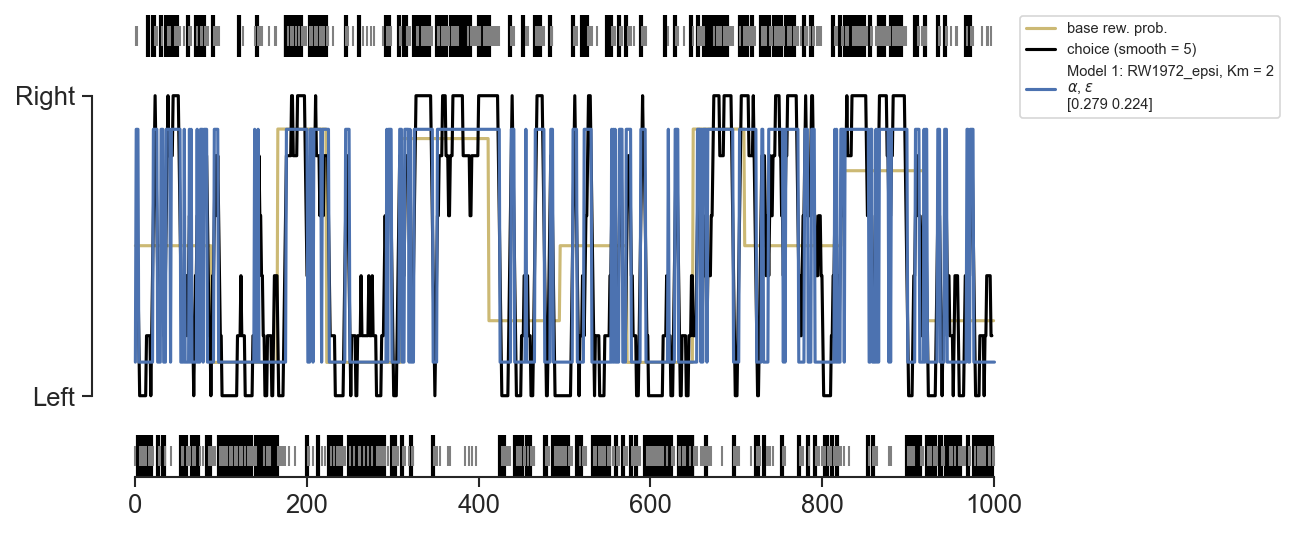

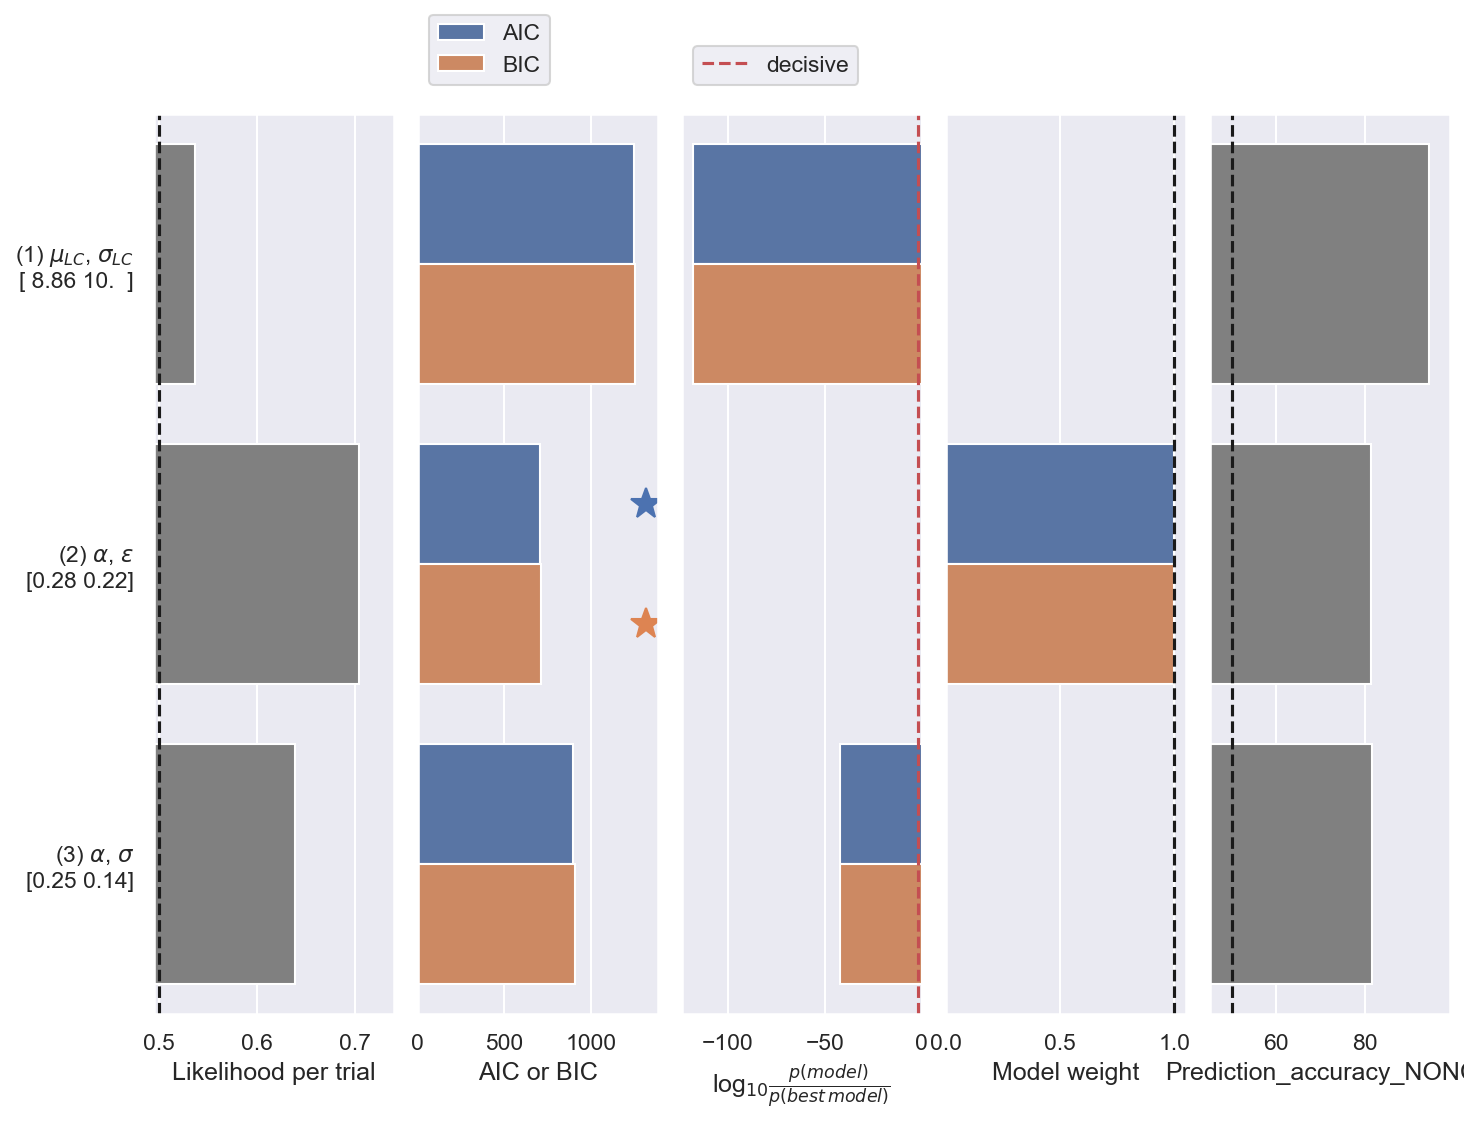

In [46]:
choice_history, reward_history, p_reward = generate_fake_data('RW1972_epsi', ['learn_rate','epsilon'], [0.3, 0.2])
model_comparison = BanditModelComparison(choice_history, reward_history, p_reward, models = [1,2,5])
model_comparison.fit(pool = mp.Pool(processes=n_worker), plot_predictive=[1]) # Plot predictive traces for the 1st, 2nd, and 3rd models
model_comparison.show()
model_comparison.plot()

# Models Fit to Real Data 

In [25]:
# we initialize a Q learning forager 
forager_RW = ForagerQLearning(number_of_learning_rate=1,number_of_forget_rate=0, choice_kernel = 'one_step', action_selection = 'epsilon-greedy')
# Fit the model to recover parameters
forager_RW.fit(
    choice_history_real_data,
    reward_history_real_data,
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

2025-08-15 18:02:13,092 - utils_model_recovery - INFO - Fitting the model using the whole dataset...
INFO:utils_model_recovery:Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 155.81788849902875
differential_evolution step 2: f(x)= 155.81788849902875
differential_evolution step 3: f(x)= 154.28538322756367
differential_evolution step 4: f(x)= 154.28538322756367
differential_evolution step 4: f(x)= 154.28538322756367
differential_evolution step 5: f(x)= 153.56176074846115
differential_evolution step 6: f(x)= 153.434736366893
differential_evolution step 7: f(x)= 153.434736366893
differential_evolution step 8: f(x)= 153.434736366893
differential_evolution step 9: f(x)= 150.98055442830835
differential_evolution step 10: f(x)= 150.98055442830835
differential_evolution step 11: f(x)= 148.48636757528035
differential_evolution step 12: f(x)= 148.48636757528035
differential_evolution step 13: f(x)= 143.42596074329106
differential_evolution step 14: f(x)= 143.42596074329106
differential_evolution step 15: f(x)= 143.42596074329106
differential_evolution step 16: f(x)= 143.42596074329106
differential_evolution step 17: f(x)= 143.42596

(                          message: Optimization terminated successfully.
                           success: True
                               fun: 138.27609720104851
                                 x: [ 1.842e-01  2.032e-01 -9.427e-02
                                      1.379e-01]
                               nit: 43
                              nfev: 2846
                        population: [[ 1.842e-01  2.032e-01 -9.427e-02
                                       1.383e-01]
                                     [ 1.823e-01  2.119e-01 -8.864e-02
                                       1.480e-01]
                                     ...
                                     [ 1.889e-01  1.774e-01 -5.734e-02
                                       1.469e-01]
                                     [ 1.740e-01  1.900e-01 -8.545e-02
                                       1.450e-01]]
               population_energies: [ 1.383e+02  1.409e+02 ...  1.409e+02
                               

In [27]:
forager_RW.plot_fitted_session(if_plot_latent=True)

(<Figure size 3000x600 with 2 Axes>, [<Axes: >, <Axes: xlabel='Trial number'>])

# Potential projects
- Fit multiple models to real data
- Select a different task environment
- Explore the behavioral model list provided but not introduced

# References

- Wilson, R. C., & Collins, A. G. (2019). Ten simple rules for the computational modeling of behavioral data. *eLife*, 8, e49547. https://doi.org/10.7554/eLife.49547  
- Palminteri, S., Wyart, V., & Koechlin, É. (2017). The importance of falsification in computational cognitive modeling. *Trends in Cognitive Sciences*, 21(6), 425–433. https://doi.org/10.1016/j.tics.2017.03.011
- (Rescorla & Wagner, 1972)